### Задание:

1. обучить рукописную сверточную нейронную сеть (с падением размера ядра свертки и последовательностью блоков свертка-пулинг (conv-pool)-(conv-pool)-...) на датасете cifar-10
2. оценить рост точности при увеличении ширины сети (больше фильтров)
3. оценить рост точности при увеличении глубины сети (больше слоев)
4. *сравнить с точностью полносвязной сети для этой выборки

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten

import os

In [2]:
tf.random.set_seed(1)

In [11]:
results = pd.DataFrame() # сводная таблица результатов
desc = [] # описание
train_acc = [] # результат на трейне
test_acc = [] # результат на тесте

In [5]:
# установка параметров нейросети
batch_size = 32
num_classes = 10
epochs = 8

# разделение тренировочной и тестовой выборки
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'тренировочные примеры')
print(X_test.shape[0], 'тестовые примеры')

# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


X_train = X_train / 255.0
X_test = X_test / 255.0

170500096/170498071 [==============================] - 223s 1us/step
X_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


In [6]:
classes = ['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

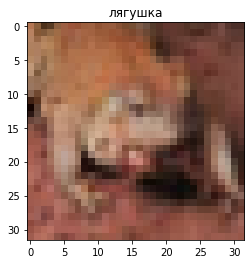

In [7]:
N = 5

plt.imshow(X_test[N])
plt.title(classes[np.argmax(y_test[N,:])])
plt.show()

### 1. Обучить рукописную сверточную нейронную сеть (с падением размера ядра свертки и последовательностью блоков свертка-пулинг (conv-pool)-(conv-pool)-...) на датасете cifar-10


In [9]:
# конфигурирование слоев нейросети
model_1 = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model_1.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model_1.add(Activation('relu'))
model_1.add(Conv2D(32, (3, 3)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

model_1.add(Conv2D(64, (3, 3), padding='same'))
model_1.add(Activation('relu'))
model_1.add(Conv2D(64, (3, 3)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

# полносвязные слои нейронной сети
model_1.add(Flatten())
model_1.add(Dense(512))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes))
model_1.add(Activation('softmax'))

model_1.summary()
# компиляция модели
model_1.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 64)       

In [10]:
history_1 = model_1.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_test, y_test))

Epoch 1/8
1563/1563 [==============================] - 144s 92ms/step - loss: 1.7491 - accuracy: 0.3492 - val_loss: 1.1312 - val_accuracy: 0.5886
Epoch 2/8
1563/1563 [==============================] - 152s 97ms/step - loss: 1.1547 - accuracy: 0.5891 - val_loss: 0.9509 - val_accuracy: 0.6646
Epoch 3/8
1563/1563 [==============================] - 149s 95ms/step - loss: 0.9856 - accuracy: 0.6526 - val_loss: 0.9018 - val_accuracy: 0.6862
Epoch 4/8
1563/1563 [==============================] - 155s 99ms/step - loss: 0.8851 - accuracy: 0.6899 - val_loss: 0.8483 - val_accuracy: 0.7059
Epoch 5/8
1563/1563 [==============================] - 153s 98ms/step - loss: 0.8174 - accuracy: 0.7123 - val_loss: 0.7688 - val_accuracy: 0.7357
Epoch 6/8
1563/1563 [==============================] - 156s 100ms/step - loss: 0.7738 - accuracy: 0.7293 - val_loss: 0.7974 - val_accuracy: 0.7286
Epoch 7/8
1563/1563 [==============================] - 159s 102ms/step - loss: 0.7303 - accuracy: 0.7458 - val_loss: 0.7170

In [12]:
train_loss, train_m = model_1.evaluate(X_train, y_train, verbose=2)
test_loss, test_m = model_1.evaluate(X_test, y_test, verbose=2)
print(f'train_loss: {train_loss}, train_accuracy: {train_m}')
print(f'test_loss: {test_loss}, test_accuracy: {test_m}')

desc.append('Базовая модель')
train_acc.append(round(train_m, 2))
test_acc.append(round(test_m, 2))

1563/1563 - 20s - loss: 0.4841 - accuracy: 0.8403
313/313 - 5s - loss: 0.6734 - accuracy: 0.7686
train_loss: 0.48405027389526367, train_accuracy: 0.8403199911117554
test_loss: 0.6733843088150024, test_accuracy: 0.7685999870300293


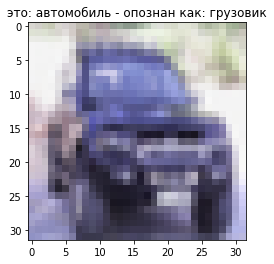

In [13]:
N = 9
y_p = model_1.predict(X_test[N:N+1])
y_t = np.argmax(y_test[N:N+1], axis = 1 )
y_i = np.argmax(y_p, axis = 1 )
plt.imshow(X_test[N])
plt.title(f'это: {classes[y_t[0]]} - опознан как: {classes[y_i[0]]}')
plt.show()

### 2. Оценить рост точности при увеличении ширины сети (больше фильтров)

In [14]:
# конфигурирование слоев нейросети
model_2 = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model_2.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model_2.add(Activation('relu'))
model_2.add(Conv2D(64, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(128, (3, 3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(Conv2D(256, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

# полносвязные слои нейронной сети
model_2.add(Flatten())
model_2.add(Dense(512))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(num_classes))
model_2.add(Activation('softmax'))

model_2.summary()
# компиляция модели
model_2.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_12 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
activation_13 (Activation)   (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 15, 128)      

In [15]:
history_2 = model_2.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_test, y_test))

Epoch 1/8
1563/1563 [==============================] - 357s 228ms/step - loss: 1.7983 - accuracy: 0.3292 - val_loss: 1.1540 - val_accuracy: 0.5839
Epoch 2/8
1563/1563 [==============================] - 378s 242ms/step - loss: 1.1913 - accuracy: 0.5777 - val_loss: 0.9518 - val_accuracy: 0.6698
Epoch 3/8
1563/1563 [==============================] - 342s 219ms/step - loss: 0.9829 - accuracy: 0.6565 - val_loss: 0.8686 - val_accuracy: 0.6990
Epoch 4/8
1563/1563 [==============================] - 392s 251ms/step - loss: 0.8731 - accuracy: 0.6936 - val_loss: 0.8114 - val_accuracy: 0.7150
Epoch 5/8
1563/1563 [==============================] - 438s 280ms/step - loss: 0.8035 - accuracy: 0.7194 - val_loss: 0.7678 - val_accuracy: 0.7348
Epoch 6/8
1563/1563 [==============================] - 382s 244ms/step - loss: 0.7503 - accuracy: 0.7383 - val_loss: 0.7032 - val_accuracy: 0.7586
Epoch 7/8
1563/1563 [==============================] - 413s 264ms/step - loss: 0.6950 - accuracy: 0.7588 - val_loss: 0

In [16]:
train_loss, train_m = model_2.evaluate(X_train, y_train, verbose=2)
test_loss, test_m = model_2.evaluate(X_test, y_test, verbose=2)
print(f'train_loss: {train_loss}, train_accuracy: {train_m}')
print(f'test_loss: {test_loss}, test_accuracy: {test_m}')

desc.append('Увеличено кол-во каналов')
train_acc.append(round(train_m, 2))
test_acc.append(round(test_m, 2))

1563/1563 - 66s - loss: 0.4495 - accuracy: 0.8505
313/313 - 13s - loss: 0.6705 - accuracy: 0.7691
train_loss: 0.4494900107383728, train_accuracy: 0.8504999876022339
test_loss: 0.6705303192138672, test_accuracy: 0.76910001039505


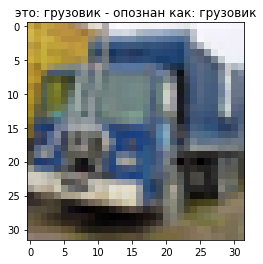

In [17]:
N = 14
y_p = model_2.predict(X_test[N:N+1])
y_t = np.argmax(y_test[N:N+1], axis = 1 )
y_i = np.argmax(y_p, axis = 1 )
plt.imshow(X_test[N])
plt.title(f'это: {classes[y_t[0]]} - опознан как: {classes[y_i[0]]}')
plt.show()

### 3. Оценить рост точности при увеличении глубины сети (больше слоев)

In [18]:
# конфигурирование слоев нейросети
model_3 = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model_3.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model_3.add(Activation('relu'))
model_3.add(Conv2D(32, (3, 3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(64, (3, 3), padding='same'))
model_3.add(Activation('relu'))
model_3.add(Conv2D(64, (3, 3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(64, (3, 3), padding='same'))
model_3.add(Activation('relu'))
model_3.add(Conv2D(64, (3, 3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.25))


# полносвязные слои нейронной сети
model_3.add(Flatten())
model_3.add(Dense(512))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(num_classes))
model_3.add(Activation('softmax'))

model_3.summary()
# компиляция модели
model_3.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_18 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_19 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 15, 15, 64)       

In [19]:
history_3 = model_3.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_test, y_test))                       

Epoch 1/8
1563/1563 [==============================] - 141s 89ms/step - loss: 1.9266 - accuracy: 0.2706 - val_loss: 1.3007 - val_accuracy: 0.5235
Epoch 2/8
1563/1563 [==============================] - 130s 83ms/step - loss: 1.3437 - accuracy: 0.5130 - val_loss: 1.1357 - val_accuracy: 0.5946
Epoch 3/8
1563/1563 [==============================] - 129s 83ms/step - loss: 1.1549 - accuracy: 0.5878 - val_loss: 1.0955 - val_accuracy: 0.6134
Epoch 4/8
1563/1563 [==============================] - 129s 83ms/step - loss: 1.0602 - accuracy: 0.6237 - val_loss: 0.9784 - val_accuracy: 0.6552
Epoch 5/8
1563/1563 [==============================] - 130s 83ms/step - loss: 1.0006 - accuracy: 0.6455 - val_loss: 0.9313 - val_accuracy: 0.6731
Epoch 6/8
1563/1563 [==============================] - 130s 83ms/step - loss: 0.9404 - accuracy: 0.6692 - val_loss: 0.8399 - val_accuracy: 0.7077
Epoch 7/8
1563/1563 [==============================] - 141s 90ms/step - loss: 0.8836 - accuracy: 0.6880 - val_loss: 0.8089 -

In [20]:
train_loss, train_m = model_3.evaluate(X_train, y_train, verbose=2)
test_loss, test_m = model_3.evaluate(X_test, y_test, verbose=2)
print(f'train_loss: {train_loss}, train_accuracy: {train_m}')
print(f'test_loss: {test_loss}, test_accuracy: {test_m}')

desc.append('Увеличено кол-во слоев')
train_acc.append(round(train_m, 2))
test_acc.append(round(test_m, 2))

1563/1563 - 23s - loss: 0.6860 - accuracy: 0.7613
313/313 - 5s - loss: 0.7853 - accuracy: 0.7289
train_loss: 0.6859843134880066, train_accuracy: 0.7613000273704529
test_loss: 0.7853162288665771, test_accuracy: 0.7289000153541565


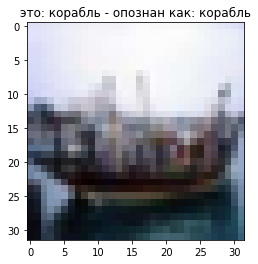

In [21]:
N = 18
y_p = model_3.predict(X_test[N:N+1])
y_t = np.argmax(y_test[N:N+1], axis = 1 )
y_i = np.argmax(y_p, axis = 1 )
plt.imshow(X_test[N])
plt.title(f'это: {classes[y_t[0]]} - опознан как: {classes[y_i[0]]}')
plt.show()

### 4. Полносвязная сеть для этой выборки

In [22]:
# конфигурирование слоев нейросети
model_4 = Sequential()

# полносвязные слои нейронной сети
model_4.add(Flatten(input_shape=X_train.shape[1:]))
model_4.add(Dense(512))
model_4.add(Activation('relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(num_classes))
model_4.add(Activation('softmax'))

model_4.summary()
# компиляция модели
model_4.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               1573376   
_________________________________________________________________
activation_26 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                5130      
_________________________________________________________________
activation_27 (Activation)   (None, 10)                0         
Total params: 1,578,506
Trainable params: 1,578,506
Non-trainable params: 0
____________________________________________

In [23]:
history_4 = model_4.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_test, y_test))

Epoch 1/8
1563/1563 [==============================] - 16s 10ms/step - loss: 2.2859 - accuracy: 0.1840 - val_loss: 1.9282 - val_accuracy: 0.3135
Epoch 2/8
1563/1563 [==============================] - 17s 11ms/step - loss: 2.0403 - accuracy: 0.2332 - val_loss: 1.9291 - val_accuracy: 0.3048
Epoch 3/8
1563/1563 [==============================] - 17s 11ms/step - loss: 2.0156 - accuracy: 0.2392 - val_loss: 1.8869 - val_accuracy: 0.3277
Epoch 4/8
1563/1563 [==============================] - 17s 11ms/step - loss: 2.0009 - accuracy: 0.2490 - val_loss: 1.8736 - val_accuracy: 0.3222
Epoch 5/8
1563/1563 [==============================] - 17s 11ms/step - loss: 1.9931 - accuracy: 0.2472 - val_loss: 1.8592 - val_accuracy: 0.3295
Epoch 6/8
1563/1563 [==============================] - 17s 11ms/step - loss: 1.9843 - accuracy: 0.2532 - val_loss: 1.8632 - val_accuracy: 0.3284
Epoch 7/8
1563/1563 [==============================] - 17s 11ms/step - loss: 1.9792 - accuracy: 0.2545 - val_loss: 1.8524 - val_ac

In [24]:
train_loss, train_m = model_4.evaluate(X_train, y_train, verbose=2)
test_loss, test_m = model_4.evaluate(X_test, y_test, verbose=2)
print(f'train_loss: {train_loss}, train_accuracy: {train_m}')
print(f'test_loss: {test_loss}, test_accuracy: {test_m}')

desc.append('Полносвязная сеть')
train_acc.append(round(train_m, 2))
test_acc.append(round(test_m, 2))

1563/1563 - 3s - loss: 1.8116 - accuracy: 0.3557
313/313 - 1s - loss: 1.8194 - accuracy: 0.3463
train_loss: 1.8115648031234741, train_accuracy: 0.355679988861084
test_loss: 1.8194339275360107, test_accuracy: 0.34630000591278076


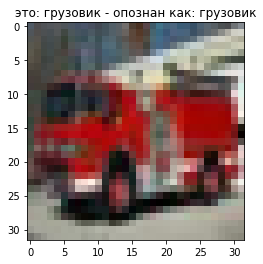

In [25]:
N = 23
y_p = model_4.predict(X_test[N:N+1])
y_t = np.argmax(y_test[N:N+1], axis = 1 )
y_i = np.argmax(y_p, axis = 1 )
plt.imshow(X_test[N])
plt.title(f'это: {classes[y_t[0]]} - опознан как: {classes[y_i[0]]}')
plt.show()

In [26]:
results['desc'] = desc
results['train_acc'] = train_acc
results['test_acc'] = test_acc

In [27]:
results

,desc,train_acc,test_acc
0,Базовая модель,0.84,0.77
1,Увеличено кол-во каналов,0.85,0.77
2,Увеличено кол-во слоев,0.76,0.73
3,Полносвязная сеть,0.36,0.35


### Выводы:<br>
- увеличение количества каналов дало минимальное преимещество относительно базовой модели;
- увеличение глубины сети уменьшило показатель метрики качества;
- у полносвязной сети качество заметно ниже, чем у базовой модели со сверточными слоями.